# Packages

In [1]:
import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import norm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder

In [5]:
df=pd.read_csv('df_all_variables.csv',index_col=0)
df.shape

(380, 337)

In [6]:
# Podział na X i y

df_xy=df.drop(['HomeTeam','AwayTeam'],axis=1)
y=df_xy.loc[10:,'FTR']
X=df_xy.loc[10:,df_xy.columns != 'FTR']

# Preprocessing

In [186]:
## Prepocessing
# 1. Inputing null values 
# 2. Treting outliers
# 3. Scaling numerical variables

### 1. Missing values

In [5]:
missing=X.isnull().mean()
missing.tail()

DS_H             0.027027
DS_A             0.027027
HGExp            0.027027
AGExp            0.027027
ExpDifference    0.027027
dtype: float64

In [6]:
# averages instead of missing values

X_names=X.columns
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') 
imputer = imputer.fit(X)
X = imputer.transform(X)
X = pd.DataFrame(X, columns = X_names)

### 2. Outliers

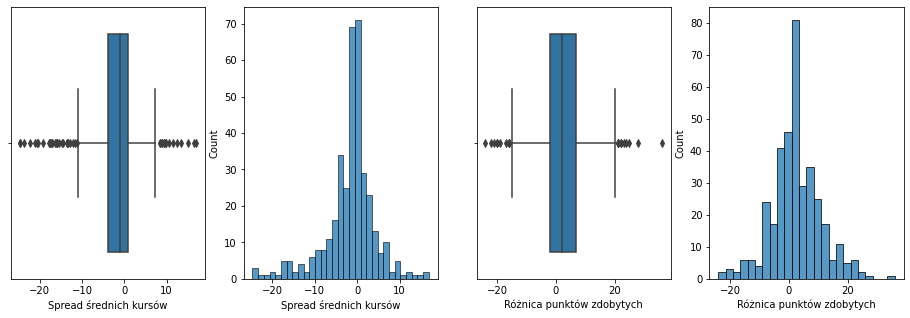

In [7]:
fig, axs = plt.subplots(ncols=4,figsize=(16,5))
sns.boxplot(x=X['Spread_avg'],ax=axs[0]).set(xlabel='Spread średnich kursów')
sns.histplot(x=X['Spread_avg'], ax=axs[1]).set(xlabel='Spread średnich kursów')
sns.boxplot(x=X['PointsDifference'],ax=axs[2]).set(xlabel='Różnica punktów zdobytych')
sns.histplot(x=X['PointsDifference'], ax=axs[3]).set(xlabel='Różnica punktów zdobytych')

plt.savefig('outliers_plots.jpg',bbox_inches='tight')

In [8]:
# replace outliers with quantiles 0.95 and 0.05

def outlier_correcter(data,quantile=0.95):
    for col in data.columns:
        data[col] = data[col].clip(lower=data[col].quantile(1-quantile), upper=data[col].quantile(quantile))
    return data

X=outlier_correcter(data=X, quantile=0.95)

### 3. Scalling variables

In [9]:
# normalization (0-1 scale)

scaler = MinMaxScaler()
# transform data
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = X_names)

In [10]:
y=y.reset_index(drop=True)
df=pd.concat([X,y],axis=1)
df.to_csv('df_after_preprocessing.csv')

# Exploratory Data Analysis

In [57]:
target=['FTR']
features=['cHBFTG', 'cHBxG','HAvgValue','AvgH','BHPoints','HomeElo']
df=df[target+features]
df.head()

,FTR,cHBFTG,cHBxG,HAvgValue,AvgH,BHPoints,HomeElo
0,H,NaN,NaN,7190000.0,4.02,NaN,1671.978882
1,H,NaN,NaN,17890000.0,1.55,NaN,1925.871948
2,A,NaN,NaN,3940000.0,3.19,NaN,1709.373291
3,H,NaN,NaN,20780000.0,1.26,NaN,1923.202026
4,H,NaN,NaN,11410000.0,1.97,NaN,1771.193726


### Class Distribution 

In [95]:
# Class distribution analysis
print(df[target].value_counts())
df[target].value_counts(normalize=True)*100

FTR
H      163
A      129
D       88
dtype: int64


FTR
H      42.894737
A      33.947368
D      23.157895
dtype: float64

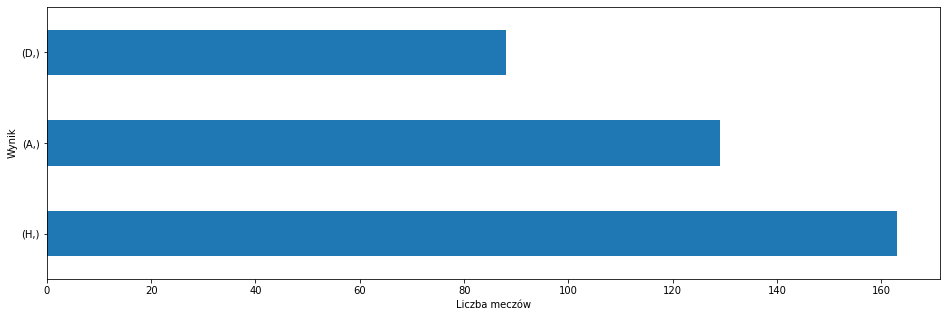

In [93]:
df[target].value_counts().plot(kind='barh',figsize=(16,5)).set(xlabel='Liczba meczów',ylabel='Wynik')
plt.savefig('class_distr.jpg',bbox_inches='tight')

### Descriptive statistics

In [94]:
st_opis=df.describe().round(2)
st_opis

,cHBFTG,cHBxG,HAvgValue,AvgH,BHPoints,HomeElo
count,370.00,370.00,380.00,380.00,370.00,380.00
mean,1.38,1.47,11433000.00,3.10,25.99,1781.67
std,0.62,0.45,5808506.45,2.51,18.56,109.56
min,0.00,0.40,3320000.00,1.11,0.00,1598.45
25%,1.00,1.18,8007500.00,1.65,12.00,1702.25
50%,1.25,1.35,9890000.00,2.33,22.00,1748.27
75%,1.66,1.67,15042500.00,3.28,37.00,1846.17
max,4.00,3.00,25740000.00,18.09,90.00,2055.69


### Goals variability over time

In [16]:
for index in range(30,len(df),10):
    df.loc[index:index+10,'AvgLGH_ruchome']=df.loc[index-30:index+10,'AvgLGH_nieskumulowane'].mean()
    df.loc[index:index+10,'AvgLGA_ruchome']=df.loc[index-30:index+10,'AvgLGA_nieskumulowane'].mean()

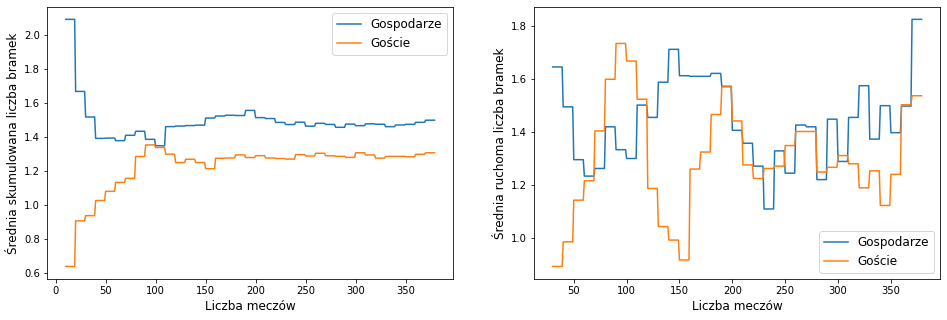

In [20]:
fig, axs = plt.subplots(ncols=2,figsize=(16,5))
axs[0].plot(df['AvgLGH'])
axs[0].plot(df['AvgLGA'])

axs[0].set_xlabel('Liczba meczów',fontsize=12)
axs[0].set_ylabel('Średnia skumulowana liczba bramek',fontsize=12)
axs[0].legend(['Gospodarze','Goście'],fontsize=12)

axs[1].plot(df['AvgLGH_ruchome'])
axs[1].plot(df['AvgLGA_ruchome'])

axs[1].set_xlabel('Liczba meczów',fontsize=12)
axs[1].set_ylabel('Średnia ruchoma liczba bramek',fontsize=12)
axs[1].legend(['Gospodarze','Goście'],fontsize=12)

fig.savefig('gole_zmiennosc.jpg',bbox_inches='tight')

### Correlation between goals and xG

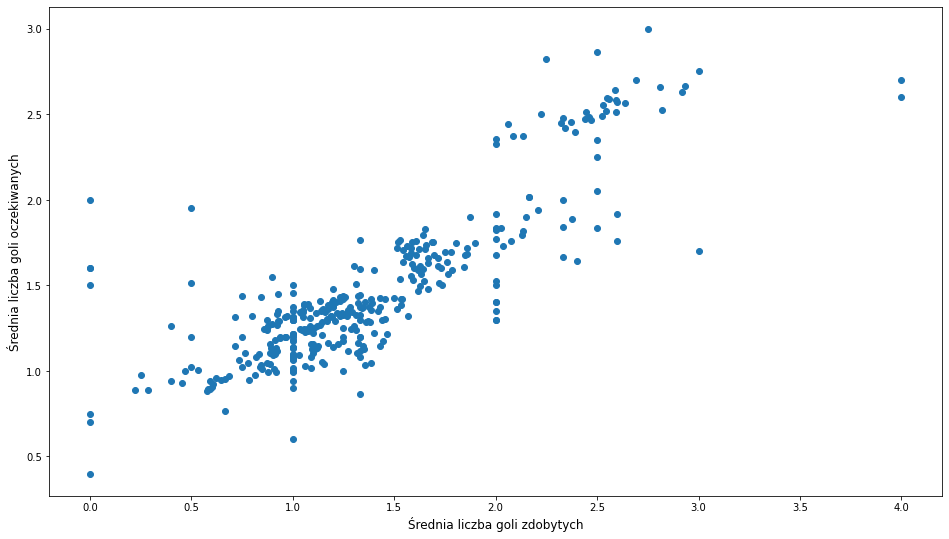

In [124]:
 

plt.figure(figsize=(16,9))
plt.scatter(x=df['cHBFTG'], y=df['cHBxG']) 

plt.xlabel('Średnia liczba goli zdobytych',fontsize=12)
plt.ylabel('Średnia liczba goli oczekiwanych',fontsize=12)

plt.savefig('gole_a_xg.jpg',bbox_inches='tight')

### Correaltions between target and features

In [133]:
# correlation matrix

corr = df[target+features].corr()
corr=corr.round(2)

In [17]:
# missing values

print("Missing values distribution: ")
print(df.isnull().mean())
print("")

Missing values distribution: 
FTR                   0.000000
cFTGDifference        0.052632
cxGDifference         0.052632
HomeAdv               0.000000
HomeAdv2              0.000000
EloDifference         0.000000
AvgValueDifference    0.000000
Spread_avg            0.000000
PointsDifference      0.052632
dtype: float64



<AxesSubplot:>

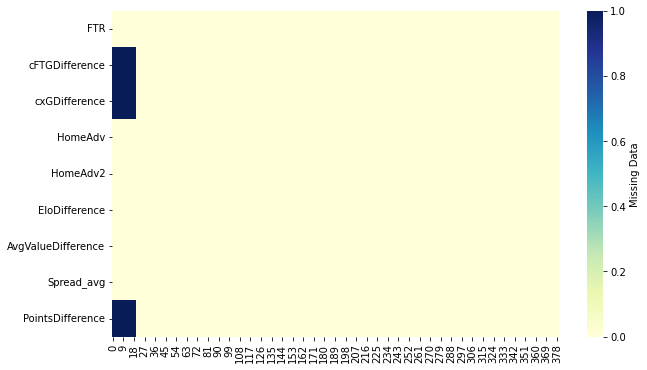

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),cmap="YlGnBu",cbar_kws={'label': 'Missing Data'})

In [199]:
# train and test split

num_features=['cFTGDifference', 'cxGDifference','EloDifference','AvgValueDifference','Spread_avg','PointsDifference']

X_train,X_test,y_train,y_test=functions.train_test_split(df=df,features=num_features,start=1,window=30,forecast=7)

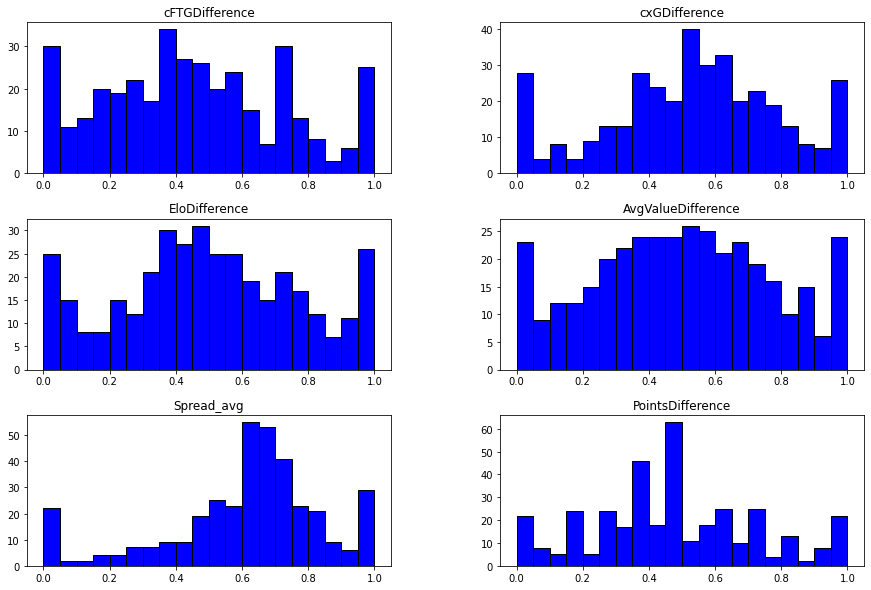

In [200]:
# Histograms

df[num_features].hist(bins=20, figsize=(15,10),grid=False, facecolor='blue', edgecolor='k')
plt.show()

In [126]:
# Correlation matrix

corr = df[target+features].corr()
corr

,Ref,MaxH,MaxA,MaxD,AvgH,AvgA,AvgD,AvgLG,AvgLGH,AvgLGA,...,AvgValueDifference,AvgAgeDifference,ForeignerDifference,AS_H,AS_A,DS_H,DS_A,HGExp,AGExp,ExpDifference
Ref,1.000000,-0.020587,0.046805,0.039596,-0.023794,0.048297,0.038191,0.000717,0.046752,-0.037519,...,0.039654,-0.013313,0.044691,0.035085,-0.063423,0.100257,-0.005128,0.030183,0.005633,0.018584
MaxH,-0.020587,1.000000,-0.415376,0.152747,0.998532,-0.438191,0.156298,0.073469,-0.005849,0.058997,...,-0.751544,0.248984,-0.032312,-0.269162,0.435397,0.204796,-0.415440,-0.391864,0.523422,-0.538464
MaxA,0.046805,-0.415376,1.000000,0.814284,-0.433928,0.997698,0.811052,0.003405,0.067644,-0.052537,...,0.753585,-0.248775,0.045240,0.572610,-0.264128,-0.396104,0.228675,0.562753,-0.442897,0.619452
MaxD,0.039596,0.152747,0.814284,1.000000,0.132314,0.801871,0.998340,0.066232,0.064785,-0.003830,...,0.361521,-0.124390,0.040907,0.488946,0.028377,-0.290960,0.007798,0.401067,-0.113343,0.340692
AvgH,-0.023794,0.998532,-0.433928,0.132314,1.000000,-0.457368,0.135744,0.069863,-0.005988,0.056448,...,-0.770597,0.255659,-0.033123,-0.282581,0.444414,0.211279,-0.422725,-0.405840,0.532658,-0.552970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DS_H,0.100257,0.204796,-0.396104,-0.290960,0.211279,-0.400105,-0.289890,-0.002743,0.052287,-0.031530,...,-0.312507,0.204058,0.057387,-0.320607,-0.047536,1.000000,0.154083,-0.175054,0.617195,-0.431531
DS_A,-0.005128,-0.415440,0.228675,0.007798,-0.422725,0.241195,0.008497,-0.135567,-0.021697,-0.128179,...,0.333628,-0.056233,0.234061,0.014906,-0.441326,0.154083,1.000000,0.571313,-0.302598,0.555625
HGExp,0.030183,-0.391864,0.562753,0.401067,-0.405840,0.574721,0.398329,-0.170029,0.005756,-0.178856,...,0.530840,-0.037652,0.128168,0.752346,-0.264674,-0.175054,0.571313,1.000000,-0.353483,0.884775
AGExp,0.005633,0.523422,-0.442897,-0.113343,0.532658,-0.458782,-0.112899,0.109328,0.021532,0.101156,...,-0.514877,0.195220,-0.045086,-0.238570,0.654430,0.617195,-0.302598,-0.353483,1.000000,-0.748686


In [204]:
df_a=df[df['FTR']=='A']
df_d=df[df['FTR']=='D']
df_h=df[df['FTR']=='H']
corr_a=df_a.corr()
corr_a

,cFTGDifference,cxGDifference,HomeAdv,HomeAdv2,EloDifference,AvgValueDifference,Spread_avg,PointsDifference
cFTGDifference,1.000000,0.627378,0.545086,0.517220,0.698651,0.629209,-0.682403,0.653079
cxGDifference,0.627378,1.000000,0.545505,0.281488,0.736401,0.676230,-0.753649,0.615925
HomeAdv,0.545086,0.545505,1.000000,0.510277,0.751716,0.739605,-0.735632,0.656906
HomeAdv2,0.517220,0.281488,0.510277,1.000000,0.516942,0.483822,-0.486253,0.670278
EloDifference,0.698651,0.736401,0.751716,0.516942,1.000000,0.931557,-0.941957,0.814494
AvgValueDifference,0.629209,0.676230,0.739605,0.483822,0.931557,1.000000,-0.923323,0.743007
Spread_avg,-0.682403,-0.753649,-0.735632,-0.486253,-0.941957,-0.923323,1.000000,-0.751488
PointsDifference,0.653079,0.615925,0.656906,0.670278,0.814494,0.743007,-0.751488,1.000000


In [53]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).format(precision=2))

,cFTGDifference,cxGDifference,HomeAdv,HomeAdv2,EloDifference,AvgValueDifference,Spread_avg,PointsDifference
cFTGDifference,nan,nan,nan,nan,nan,nan,nan,nan
cxGDifference,0.74,nan,nan,nan,nan,nan,nan,nan
HomeAdv,0.54,0.57,nan,nan,nan,nan,nan,nan
HomeAdv2,0.55,0.44,0.48,nan,nan,nan,nan,nan
EloDifference,0.75,0.76,0.76,0.58,nan,nan,nan,nan
AvgValueDifference,0.68,0.68,0.74,0.54,0.93,nan,nan,nan
Spread_avg,-0.73,-0.74,-0.68,-0.54,-0.93,-0.89,nan,nan
PointsDifference,0.67,0.66,0.64,0.67,0.78,0.71,-0.73,nan


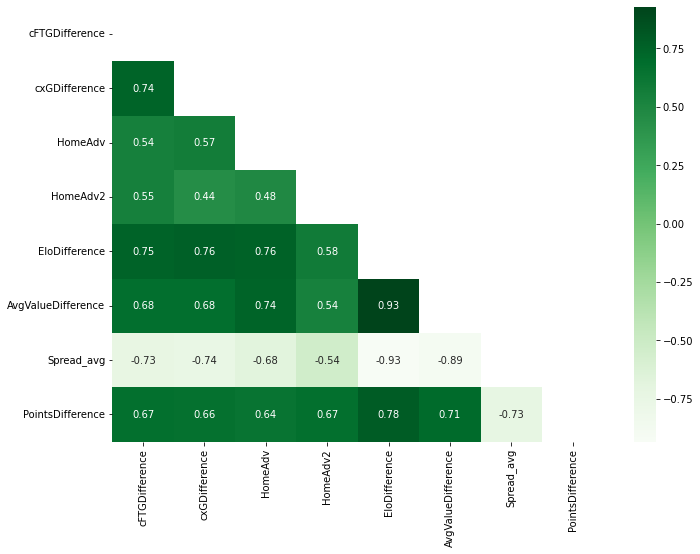

In [54]:
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

In [55]:
# Spearman corr matri

corr_spearman = df.corr(method="spearman")
corr_spearman

,cFTGDifference,cxGDifference,HomeAdv,HomeAdv2,EloDifference,AvgValueDifference,Spread_avg,PointsDifference
cFTGDifference,1.000000,0.752067,0.561168,0.556225,0.738970,0.678639,-0.720600,0.700636
cxGDifference,0.752067,1.000000,0.570279,0.469794,0.738942,0.671295,-0.742381,0.666774
HomeAdv,0.561168,0.570279,1.000000,0.478528,0.792385,0.759458,-0.840135,0.668120
HomeAdv2,0.556225,0.469794,0.478528,1.000000,0.586948,0.548789,-0.586388,0.711225
EloDifference,0.738970,0.738942,0.792385,0.586948,1.000000,0.923478,-0.956928,0.785210
AvgValueDifference,0.678639,0.671295,0.759458,0.548789,0.923478,1.000000,-0.923827,0.710663
Spread_avg,-0.720600,-0.742381,-0.840135,-0.586388,-0.956928,-0.923827,1.000000,-0.779638
PointsDifference,0.700636,0.666774,0.668120,0.711225,0.785210,0.710663,-0.779638,1.000000


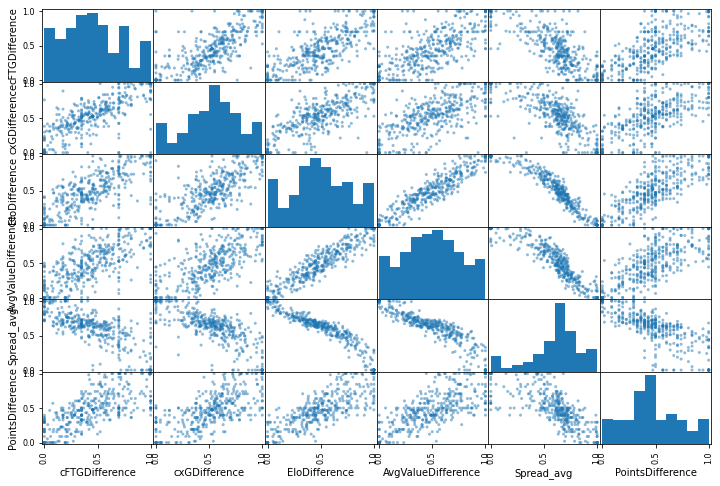

In [56]:
# Scatter plots for numeric variables

scatter_matrix(df[num_features],figsize=(12,8))
plt.show()

# Feature selection

### 1. ANOVA f test statistic

In [18]:
df=pd.read_csv('df_after_preprocessing.csv',index_col=0)

X_train,X_test,y_train,y_test=functions.train_test_split(df=df,features='all',start=1,window=30,forecast=7)

         Input_Features    F_Score
322  AvgValueDifference  41.699646
321     ValueDifference  38.831419
307             HomeAdv  37.571538
312       EloDifference  36.748303
4                  AvgH  36.220479
281          Spread_avg  35.577475
1                  MaxH  35.348660
282          Spread_max  34.415600
298       cBCDifference  26.852892
5                  AvgA  25.236595


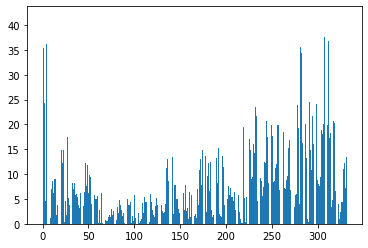

In [19]:
def select_features_f(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_train, y_train.values.ravel())
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
X_train_fs, X_test_fs, fs = select_features_f(X_train, y_train, X_test)
features_score = pd.DataFrame(fs.scores_)
features = pd.DataFrame(X.columns)
feature_score = pd.concat([features,features_score],axis=1)
feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(10,columns="F_Score"))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### 2. Mutual information statistic

   Input_Features   F_Score
45        BAForm5  0.147573
51     BALoserate  0.105630
44        BAForm4  0.101474
4            AvgH  0.093962
40    BHWinstreak  0.085467
47    BAPointsAvg  0.080988
43        BAForm3  0.080607
53   BALossesOver  0.064532
50       BALosses  0.060729
27       cABxGnet  0.060418


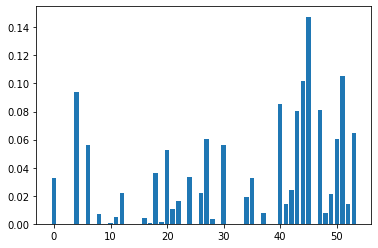

In [17]:
def select_features_mutual(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train.values.ravel())
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
X_train_fs, X_test_fs, fs = select_features_mutual(X_train, y_train, X_test)
features_score = pd.DataFrame(fs.scores_)
features = pd.DataFrame(X.columns)
feature_score = pd.concat([features,features_score],axis=1)
feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(10,columns="F_Score"))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

###

### VIF (variance inflation factor) to avoid multicollineairty

In [93]:
data=pd.concat([X_train,y_train],axis=1)
iv = data.columns
iv = iv.delete(-1)

Index(['Ref', 'MaxH', 'MaxA', 'MaxD', 'AvgH', 'AvgA', 'AvgD', 'AvgLG',
       'AvgLGH', 'AvgLGA',
       ...
       'AvgValueDifference', 'AvgAgeDifference', 'ForeignerDifference', 'AS_H',
       'AS_A', 'DS_H', 'DS_A', 'HGExp', 'AGExp', 'ExpDifference'],
      dtype='object', length=332)

In [96]:
[vif(data[iv].values, index) for index in range(len(iv))]

 
for i in range(len(iv)):
    vif_list = [vif(data[iv].values, index) for index in range(len(iv))]
    maxvif = max(vif_list)
    print("Max VIF value is ", maxvif)                     
    drop_index = vif_list.index(maxvif)
    print("For Independent variable", iv[drop_index])
    
    if maxvif > 10:
        
        print("Deleting", iv[drop_index])
        iv = iv.delete(drop_index)
        print("Final Independent_variables ", iv)

d:\Programs\Python\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Max VIF value is  inf
For Independent variable Ref
Deleting Ref
Final Independent_variables  Index(['MaxH', 'MaxA', 'MaxD', 'AvgH', 'AvgA', 'AvgD', 'AvgLG', 'AvgLGH',
       'AvgLGA', 'cHBFTG',
       ...
       'AvgValueDifference', 'AvgAgeDifference', 'ForeignerDifference', 'AS_H',
       'AS_A', 'DS_H', 'DS_A', 'HGExp', 'AGExp', 'ExpDifference'],
      dtype='object', length=331)
Max VIF value is  inf
For Independent variable MaxH
Deleting MaxH
Final Independent_variables  Index(['MaxA', 'MaxD', 'AvgH', 'AvgA', 'AvgD', 'AvgLG', 'AvgLGH', 'AvgLGA',
       'cHBFTG', 'cHBxG',
       ...
       'AvgValueDifference', 'AvgAgeDifference', 'ForeignerDifference', 'AS_H',
       'AS_A', 'DS_H', 'DS_A', 'HGExp', 'AGExp', 'ExpDifference'],
      dtype='object', length=330)
Max VIF value is  inf
For Independent variable MaxA
Deleting MaxA
Final Independent_variables  Index(['MaxD', 'AvgH', 'AvgA', 'AvgD', 'AvgLG', 'AvgLGH', 'AvgLGA', 'cHBFTG',
       'cHBxG', 'cHBS',
       ...
       'AvgValueD

In [97]:
# final variables

final_variables=['BHWinstreak', 'BHLosestreak', 'BAWinstreak', 'BALosestreak', 'cHS',
       'cHF', 'cHY', 'cHR', 'r3FTHG', 'r3HC', 'r3HY', 'r3HR', 'r4HR', 'r5HR',
       'WinsOverH', 'LossesOverH', 'WinstreakH', 'LosestreakH', 'cAF', 'cAR',
       'r3AC', 'r3AF', 'r3AY', 'r3AR', 'r4AR', 'r5FTAG', 'r5AR', 'ewm03_xGA',
       'LoserateA', 'WinsOverA', 'LossesOverA', 'WinstreakA', 'LosestreakA',
       'RestH', 'RestYesNoH', 'FormationCatH', 'FormationChangeH', 'RestA',
       'RestYesNoA', 'FormationCatA', 'FormationChangeA', 'Markov_ratingH',
       'OD_ratingH', 'OD_ratingA', 'SpreadH', 'SpreadA', 'SpreadD', 'HomeAdv',
       'HomeAdv2', 'HomeAdv3', 'HAvgAge', 'HForeigner', 'AAvgAge',
       'AForeigner']
len(final_variables)

54

In [99]:
vif_data = pd.DataFrame()
vif_data["feature"] = X[final_variables].columns
  
# calculating VIF for each feature
vif_data["VIF"] = [vif(X[final_variables].values, i)
                          for i in range(len(X[final_variables].columns))]
  
print(vif_data)

             feature       VIF
0        BHWinstreak  3.174954
1       BHLosestreak  2.851315
2        BAWinstreak  3.083420
3       BALosestreak  2.442309
4                cHS  7.035721
5                cHF  6.017118
6                cHY  9.280337
7                cHR  5.700001
8             r3FTHG  8.383790
9               r3HC  7.252152
10              r3HY  7.265995
11              r3HR  4.569446
12              r4HR  9.481844
13              r5HR  7.569897
14         WinsOverH  8.008985
15       LossesOverH  6.053426
16        WinstreakH  3.357303
17       LosestreakH  3.107037
18               cAF  8.649551
19               cAR  3.756897
20              r3AC  6.004296
21              r3AF  7.944036
22              r3AY  6.443061
23              r3AR  3.924574
24              r4AR  6.944319
25            r5FTAG  8.075733
26              r5AR  4.970354
27         ewm03_xGA  9.286375
28         LoserateA  9.287733
29         WinsOverA  5.713381
30       LossesOverA  5.923154
31      

# Unbalanced dataset (SMOTE and Random Oversampling)

In [2]:
df=pd.read_csv('df_after_preprocessing.csv',index_col=0)
y=df.loc[:,'FTR']
X=df.loc[:,df.columns != 'FTR']
X_train,X_test,y_train,y_test=functions.train_test_split(df=df,features='all',start=1,window=30,forecast=7)

In [3]:
df['FTR'].value_counts(normalize=True)*100

H    42.162162
A    34.054054
D    23.783784
Name: FTR, dtype: float64

In [4]:
Label=LabelEncoder()
y = Label.fit_transform(y.values.ravel())
Label=LabelEncoder()
y_train = Label.fit_transform(y_train.values.ravel())

In [5]:
Label.inverse_transform([0,1,2])

array(['A', 'D', 'H'], dtype=object)

In [6]:
# Random Oversampling

def oversample_random(X,y):
    # transform the dataset
    oversample = RandomOverSampler(sampling_strategy='not majority')
    X, y = oversample.fit_resample(X, y)
    X= pd.DataFrame(X, columns = X.columns)
    y= pd.DataFrame(y, columns = ['FTR'])
    data=pd.concat([X,y],axis=1)
    return data


# SMOTE

def oversample_smote(X,y):
    # transform the dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    X= pd.DataFrame(X, columns = X.columns)
    y= pd.DataFrame(y, columns = ['FTR'])
    data=pd.concat([X,y],axis=1)
    return data

In [7]:
df_sampled=oversample_smote(X_train,y_train)

In [8]:
df_sampled.to_csv('df_sampled_smote.csv')

In [9]:
df_sampled=oversample_random(X_train,y_train)

In [10]:
df_sampled.to_csv('df_sampled_random.csv')